In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor as xgb
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns

D:\Anaconda\envs\tf_gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [30]:
train = pd.read_csv("C:/Users/admin/Downloads/nyc-taxi-trip-duration/train.csv")
test = pd.read_csv("C:/Users/admin/Downloads/nyc-taxi-trip-duration/test.csv")

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [28]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


There are some outliers in the dataset, especially in the response value since the max value is about 980 hour, which is impractical. 

We will remove the outliers by removing data points that do not belong to 2 standard deviation from the mean of trip_duration

In [31]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

Looking at NYC border, its coordinate is 

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

We will filter out longitude and latitude within NYC since there are some coordinate points that fall outside these borders. 

In [32]:
train = train[(train['pickup_longitude'] <= -73.75) & (train['pickup_longitude'] >= -74.03)]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

Change the format of date/time for future use. 

In [33]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

Visualization and Analysis

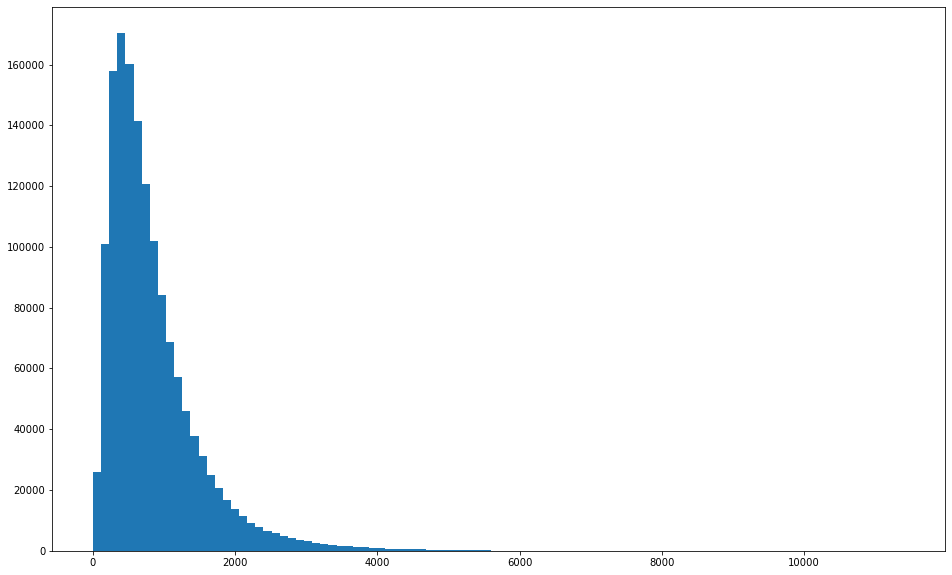

In [5]:
plt.hist(train['trip_duration'].values, bins = 100)
plt.show()

We will transform the trip_duration to see if there exists notable patterns showing up. In this case, we will apply the log transformation to the trip_duration. 

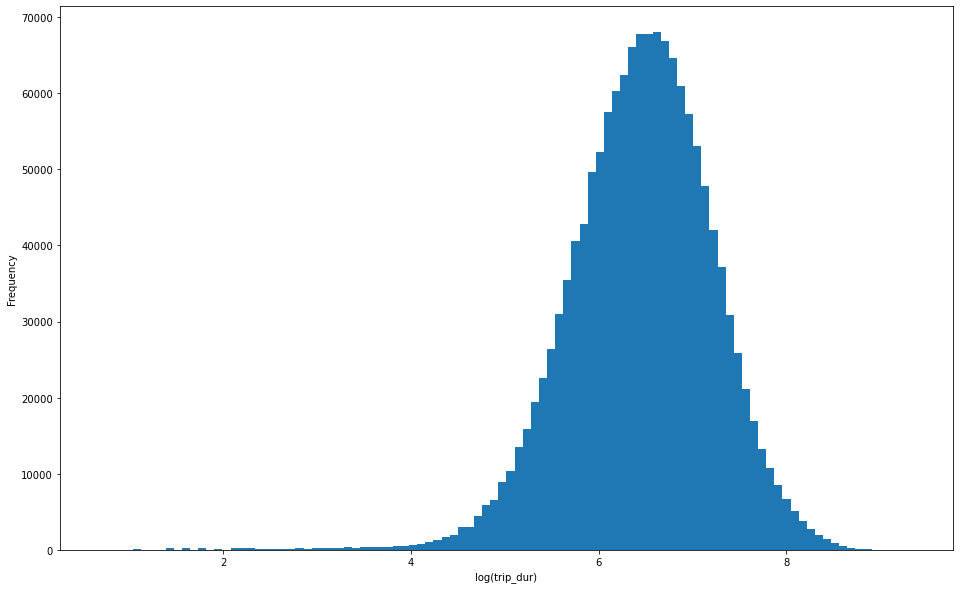

D:\Anaconda\envs\tf_gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_trip_dur', ylabel='Density'>

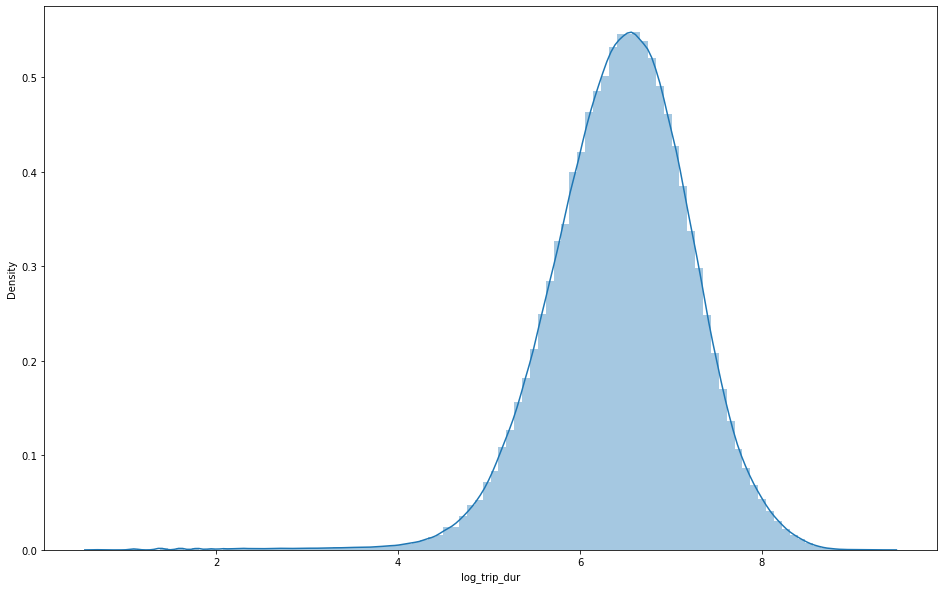

In [34]:
train['log_trip_dur'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_dur'], bins = 100)
plt.xlabel("log(trip_dur)")
plt.ylabel("Frequency")
plt.show()
sns.distplot(train["log_trip_dur"], bins =100)

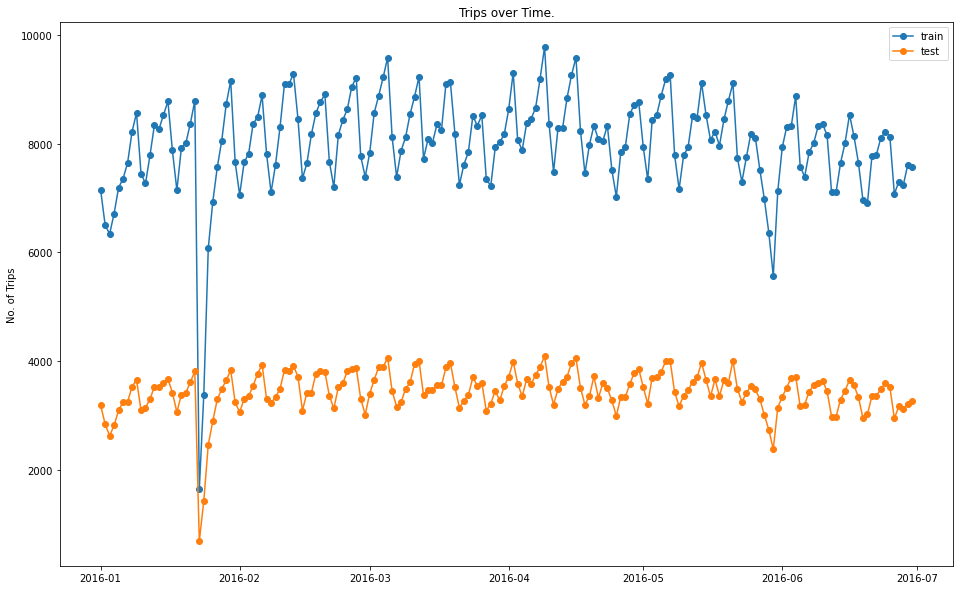

In [10]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label = 'train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label = 'test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('No. of Trips')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
D:\Anaconda\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Time per store_and_fwd_flag'}, xlabel='store_and_fwd_flag', ylabel='Time in Seconds'>

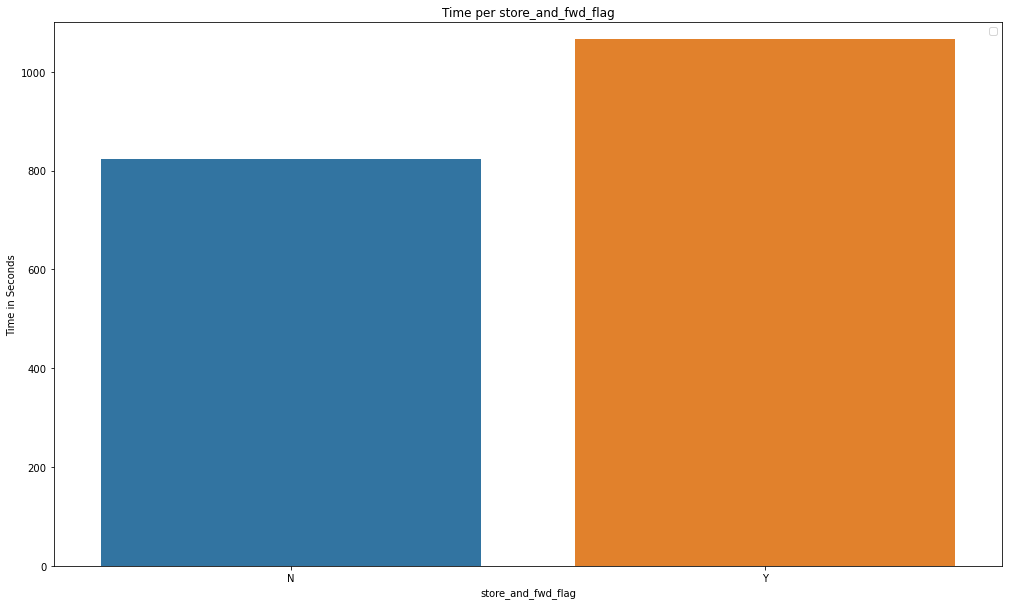

In [32]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index,snwflag.values)

It seems that store_and_fwd_flag discriminates well between travel times. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
D:\Anaconda\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Time per store_and_fwd_flag'}, xlabel='passenger_count', ylabel='Time in Seconds'>

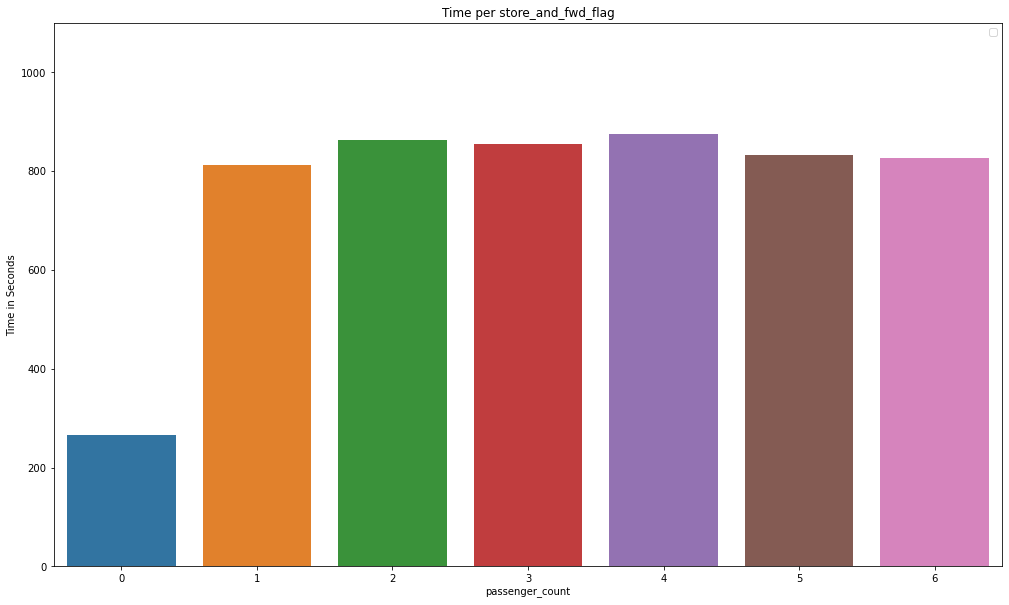

In [33]:
pc = train.groupby('passenger_count')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

There is no significant difference among travel time explained by the number of passengers in any trip.

Coordinate Mapping

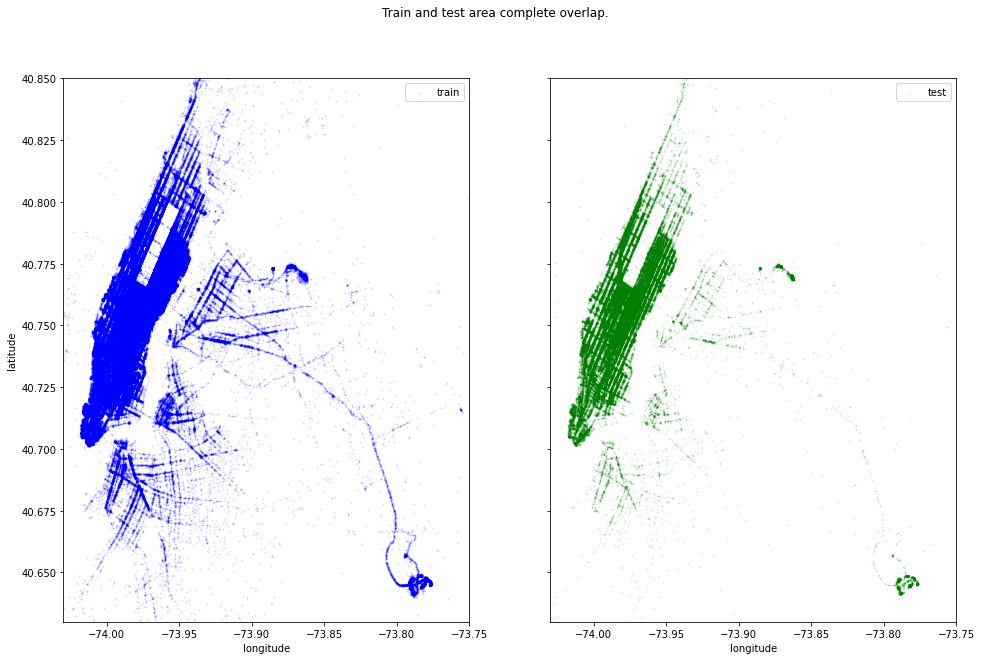

In [35]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:1000000], train['pickup_latitude'].values[:1000000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [36]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [37]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values) 

Data Extraction

In [38]:
## Extracting month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [39]:
## Extracting day of month
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day

In [40]:
## Extracting hour
train['hour'] = train['pickup_datetime'].dt.hour
test['hour'] = test['pickup_datetime'].dt.hour

In [41]:
## Extracting day of week
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek

In [42]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,log_trip_dur,distance_haversine,distance_dummy_manhattan,direction,Month,DayofMonth,hour,dayofweek
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,6.122493,1.498521,1.735433,99.970196,3,14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,6.498282,1.805507,2.430506,-117.153768,6,12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,7.661527,6.385098,8.203575,-159.680165,1,19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6.063785,1.485498,1.661331,-172.737700,4,6,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,6.077642,1.188588,1.199457,179.473585,3,26,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,6.658011,1.225080,1.665895,-119.059338,4,8,13,4
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,6.486161,6.049836,8.058580,25.342196,1,10,7,6
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6.639876,7.824606,10.645646,-150.788492,4,22,6,4
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,5.924256,1.092564,1.521850,35.033294,1,5,15,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
D:\Anaconda\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Travel time vs hour'}, xlabel='hour', ylabel='Travel time'>

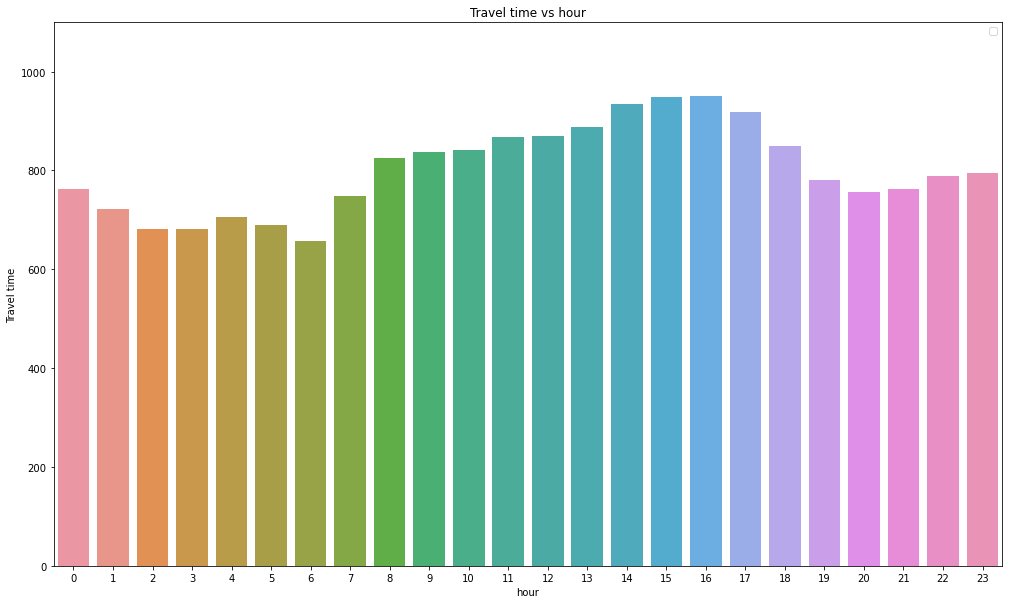

In [43]:
durbyhour = train.groupby('hour')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Travel time vs hour')
plt.legend(loc=0)
plt.ylabel('Travel time')
sns.barplot(durbyhour.index,durbyhour.values)

We can see that the duration for a trip around 4pm or 3pm seems to be the longest due to the traffic jam. 

In [44]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')


month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [45]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)


In [46]:
train = train.drop(['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'Month', 'DayofMonth', 'dayofweek', 'pickup_latitude', 'pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'hour'], axis = 1)
Test = test['id']
test = test.drop(['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'Month', 'DayofMonth', 'dayofweek', 'pickup_latitude', 'pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'hour'], axis = 1)
train = train.drop(['dropoff_datetime', 'trip_duration'], axis = 1)


In [47]:
train

,pickup_datetime,pickup_date,log_trip_dur,distance_haversine,distance_dummy_manhattan,direction
0,2016-03-14 17:24:55,2016-03-14,6.122493,1.498521,1.735433,99.970196
1,2016-06-12 00:43:35,2016-06-12,6.498282,1.805507,2.430506,-117.153768
2,2016-01-19 11:35:24,2016-01-19,7.661527,6.385098,8.203575,-159.680165
3,2016-04-06 19:32:31,2016-04-06,6.063785,1.485498,1.661331,-172.737700
4,2016-03-26 13:30:55,2016-03-26,6.077642,1.188588,1.199457,179.473585
...,...,...,...,...,...,...
1458639,2016-04-08 13:31:04,2016-04-08,6.658011,1.225080,1.665895,-119.059338
1458640,2016-01-10 07:35:15,2016-01-10,6.486161,6.049836,8.058580,25.342196
1458641,2016-04-22 06:57:41,2016-04-22,6.639876,7.824606,10.645646,-150.788492
1458642,2016-01-05 15:56:26,2016-01-05,5.924256,1.092564,1.521850,35.033294


In [48]:
train_comb = pd.concat([train, vendor_train, passenger_count_train, store_and_fwd_flag_train,
                         month_train,
                         dom_train,
                          hour_train,
                          dow_train], axis = 1)

test_comb = pd.concat([test,  vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [49]:
train_comb.shape

(1437128, 85)

In [50]:
train_comb = train_comb.drop(['pickup_datetime', 'pickup_date'], axis = 1)
test_comb = test_comb.drop(['pickup_datetime', 'pickup_date'], axis = 1)


In [51]:
train_comb.shape, test_comb.shape

((1437128, 83), (625134, 82))

In [52]:
train_comb

,log_trip_dur,distance_haversine,distance_dummy_manhattan,direction,vi_1,vi_2,pc_0,pc_1,pc_2,pc_3,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,6.122493,1.498521,1.735433,99.970196,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,6.498282,1.805507,2.430506,-117.153768,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,7.661527,6.385098,8.203575,-159.680165,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,6.063785,1.485498,1.661331,-172.737700,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,6.077642,1.188588,1.199457,179.473585,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,6.658011,1.225080,1.665895,-119.059338,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1458640,6.486161,6.049836,8.058580,25.342196,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1458641,6.639876,7.824606,10.645646,-150.788492,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1458642,5.924256,1.092564,1.521850,35.033294,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
train_set, valid_set = train_test_split(train_comb[0:train_comb.shape[0]], test_size = 0.3, random_state = 1)
X_train = train_set.drop(['log_trip_dur'], axis = 1)
Y_train = train_set['log_trip_dur']

X_valid = valid_set.drop(['log_trip_dur'], axis = 1)
Y_valid = valid_set['log_trip_dur']

Y_valid = Y_valid.reset_index().drop('index', axis = 1)
Y_train = Y_train.reset_index().drop('index', axis = 1)


In [23]:
Y_train.shape

(1005989, 1)

In [24]:
X_train_comb = train_comb.drop(['log_trip_dur'], axis = 1)
Y_train_comb = train_comb['log_trip_dur']
Y_train_comb = Y_train_comb.reset_index().drop('index', axis = 1)
dtrain_comb = xgb.DMatrix(X_train_comb, label = Y_train_comb)

dtrain = xgb.DMatrix(X_train, label = Y_train)
dvalid = xgb.DMatrix(X_valid, label = Y_valid)
dtest = xgb.DMatrix(test_comb)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]


D:\Anaconda\envs\tf_gpu\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [27]:
X_train_comb.shape

(1437128, 82)

In [55]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 0.9, 
            'max_depth': 10,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'colsample_bytree' : 1}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=20,
      maximize=False, verbose_eval=1)
print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[22:51:07] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:4.21093	valid-rmse:4.21164
[1]	train-rmse:2.96383	valid-rmse:2.96461
[2]	train-rmse:2.09695	valid-rmse:2.09789
[3]	train-rmse:1.49809	valid-rmse:1.49934
[4]	train-rmse:1.08961	valid-rmse:1.09136
[5]	train-rmse:0.81678	valid-rmse:0.81958
[6]	train-rmse:0.64065	valid-rmse:0.64474
[7]	train-rmse:0.53190	valid-rmse:0.53731
[8]	train-rmse:0.46837	valid-rmse:0.47514
[9]	train-rmse:0.43223	valid-rmse:0.44006
Best RMSE: 0.44 with 10 rounds


In [25]:
params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [26]:
num_boost_round=999
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=1,
    nfold=10,
    metrics={'rmse'},
    early_stopping_rounds=10
)

In [27]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,4.210961,0.000206,4.211039,0.002187
1,2.963900,0.000145,2.964125,0.001915
2,2.096963,0.000131,2.097443,0.001800
3,1.498202,0.000122,1.499134,0.001727
4,1.089562,0.000108,1.091204,0.001714
5,0.816675,0.000205,0.819284,0.001689
6,0.640408,0.000221,0.644280,0.001788
7,0.531815,0.000287,0.537036,0.001694
8,0.468083,0.000457,0.474651,0.001594
9,0.432041,0.000547,0.439868,0.001494


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

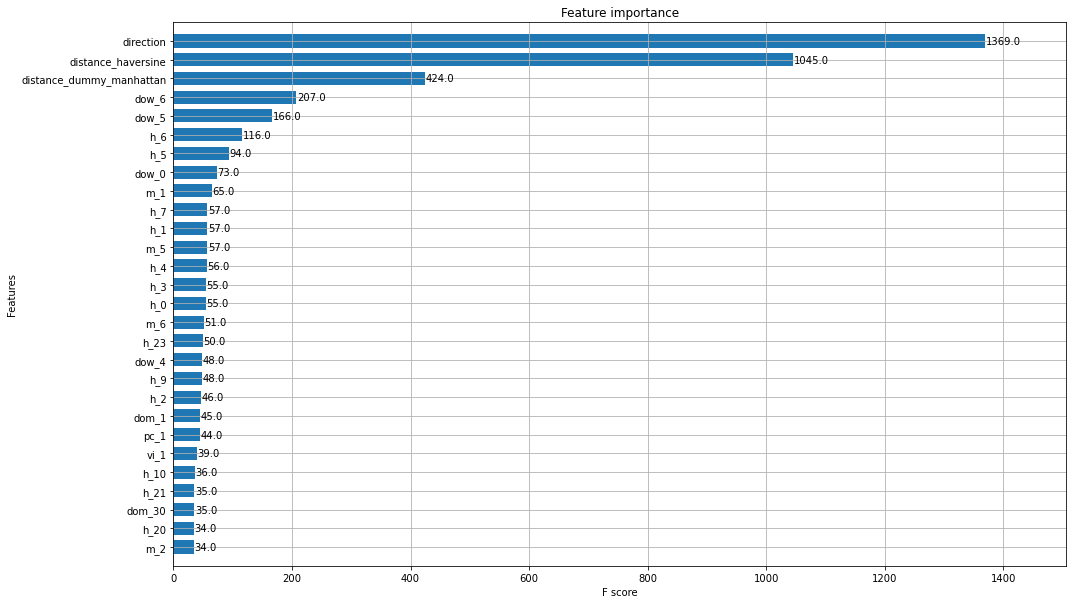

In [29]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

In [30]:
prediction = model.predict(dtest)
prediction = np.exp(prediction) - 1

In [31]:
prediction

array([ 666.383 ,  671.7098,  374.5372, ..., 1154.7432, 1345.4238,
        961.8438], dtype=float32)

In [39]:
Test

0                                                        id3004672
1                                                        id3505355
2                                                        id1217141
3                                                        id2150126
4                                                        id1598245
                                       ...                        
625130                                                   id3700764
625131                                                   id2568735
625132                                                   id1384355
625133                                                   id0621643
trip_duration    [666.383, 671.7098, 374.5372, 965.17175, 296.7...
Name: id, Length: 625135, dtype: object

In [45]:
data = {'id': list(test['id']), 'trip_duration': prediction}
submission = pd.DataFrame(data)

In [46]:
submission

,id,trip_duration
0,id3004672,666.382996
1,id3505355,671.709778
2,id1217141,374.537201
3,id2150126,965.171753
4,id1598245,296.795868
...,...,...
625129,id3008929,251.395844
625130,id3700764,1091.492676
625131,id2568735,1154.743164
625132,id1384355,1345.423828


In [53]:
submission.to_csv("D:/submission.csv", index = False)

In [51]:
sub = submission.reset_index(drop = True)

In [52]:
sub

,id,trip_duration
0,id3004672,666.382996
1,id3505355,671.709778
2,id1217141,374.537201
3,id2150126,965.171753
4,id1598245,296.795868
...,...,...
625129,id3008929,251.395844
625130,id3700764,1091.492676
625131,id2568735,1154.743164
625132,id1384355,1345.423828


In [63]:
X = train_comb.drop(['log_trip_dur'], axis = 1).values
Y = train_comb['log_trip_dur'].values

In [64]:
kf = KFold(n_splits = 10)
kf.get_n_splits(X)

10

In [65]:
KFold(n_splits = 10, random_state = None, shuffle = False)
for train_idx, valid_idx in kf.split(X):
    print('TRAIN: ', train_idx, "VALID:", valid_idx)
    X_kf_train, X_kf_valid = X[train_idx], X[valid_idx]
    Y_kf_train, Y_kf_valid = Y[train_idx], Y[valid_idx]
    

TRAIN:  [ 143713  143714  143715 ... 1437125 1437126 1437127] VALID: [     0      1      2 ... 143710 143711 143712]
TRAIN:  [      0       1       2 ... 1437125 1437126 1437127] VALID: [143713 143714 143715 ... 287423 287424 287425]
TRAIN:  [      0       1       2 ... 1437125 1437126 1437127] VALID: [287426 287427 287428 ... 431136 431137 431138]
TRAIN:  [      0       1       2 ... 1437125 1437126 1437127] VALID: [431139 431140 431141 ... 574849 574850 574851]
TRAIN:  [      0       1       2 ... 1437125 1437126 1437127] VALID: [574852 574853 574854 ... 718562 718563 718564]
TRAIN:  [      0       1       2 ... 1437125 1437126 1437127] VALID: [718565 718566 718567 ... 862275 862276 862277]
TRAIN:  [      0       1       2 ... 1437125 1437126 1437127] VALID: [ 862278  862279  862280 ... 1005988 1005989 1005990]
TRAIN:  [      0       1       2 ... 1437125 1437126 1437127] VALID: [1005991 1005992 1005993 ... 1149701 1149702 1149703]
TRAIN:  [      0       1       2 ... 1437125 1437126

In [69]:
dkftrain = xgb.DMatrix(X_kf_train, label = Y_kf_train)
dkfvalid = xgb.DMatrix(X_kf_valid, label = Y_kf_valid)
dkftest = xgb.DMatrix(test_comb.values)
watchlist = [(dkftrain, 'train'), (dkfvalid, 'valid')]





In [70]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.04, 'colsample_bytree': 0.8, 'max_depth': 15,
            'subsample': 0.75, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'gamma' : 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}  

model = xgb.train(xgb_pars, dkftrain, 500, watchlist, early_stopping_rounds=250,
                  maximize=False, verbose_eval=15)


[23:55:30] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:5.76022	valid-rmse:5.76177
[15]	train-rmse:3.14409	valid-rmse:3.14526
[30]	train-rmse:1.73989	valid-rmse:1.74134
[45]	train-rmse:1.00238	valid-rmse:1.00515
[60]	train-rmse:0.63489	valid-rmse:0.64075
[75]	train-rmse:0.47085	valid-rmse:0.48140
[90]	train-rmse:0.40617	valid-rmse:0.42117
[105]	train-rmse:0.38181	valid-rmse:0.40051
[120]	train-rmse:0.37186	valid-rmse:0.39352
[135]	train-rmse:0.36679	valid-rmse:0.39090
[150]	train-rmse:0.36321	valid-rmse:0.38986
[165]	train-

In [72]:
evalset = [(X_kf_train,Y_kf_train), (X_kf_valid , Y_kf_valid)]

In [76]:
ytest = model.predict(dkftest)

In [77]:
ytest

array([6.5744624, 6.711688 , 6.096159 , ..., 7.3850403, 7.392936 ,
       7.0831075], dtype=float32)